In [1]:
import math  
import numpy as np
import random as r
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

# Node
This class represents a model of a single node in the som map, which contains an x and y position, as well as a weight vector and assigned data vectors. Weight vectors are used to assign data vectors to nodes further down in the code.

In [2]:
class Node:
    x = 0
    y = 0
    weights = []
    vectors = []
    
    def __init__(self, x, y, weights):
        self.x = x
        self.y = y        
        self.weights = weights 
        self.vectors = []
    '''
    def getX(): 
        return x
    
    def getY(): 
        return y
    
    def getWeights(): 
        return weights
    
    def setWeights(weights): 
        self.weights = weights
    '''
        
    ''' Function calculates weight distance between this node and any given vector'''
    def getDistance(self, vector):
        distance = 0
        for i in range(len(self.weights)):
            distance += (vector[i] - self.weights[i]) * (vector[i] - self.weights[i])
        return math.sqrt(distance)
    
    ''' Function calculates weight distance between this node and another node'''
    def getNodeDistance(self, node):
        distance = 0
        for i in range(len(self.weights)):
            distance += (node.weights[i] - self.weights[i]) * (node.weights[i] - self.weights[i])
        return math.sqrt(distance)
    
    ''' Function calculates positional distance between this node and another node'''
    def getPhysicalDistance(self, node):
        dX = (self.x-node.x)
        dY = (self.y-node.y)
        return math.sqrt(dX*dX + dY*dY)
    
    ''' Function adds a vector to the vectors list'''
    def addVector(self, vector):
        self.vectors.append(vector)

# SOM
This class represents the 2D Self-Organizing Map, which includes x and y attributes for the map sizing, sigma, learning rate, and width attributes, used to implement the actual clustering.

In [16]:
class SOM:
    somMap = []
    magnitudes = []
    x = 10
    y = 10
    width = 10
    s = 1.0 # Sigma
    a = 0.5 # Learning Rate
    
    def __init__(self, x=10, y=10, s=1.0, a=0.5):
        self.x = x
        self.y = y
        self.s = s
        self.a = a
        
        if max(x, y) != 2:
            self.width = max(x, y)/2
        else:    
            self.width = max(x, y)
        
        print(self.width)
        print(math.log(self.width))
        
        # Initialize Map
        for i in range(self.x):
            self.somMap.append([Node(i, j, self.getRandomWeightVector()) for j in range(self.y)])
    
    def getRandomWeightVector(self, length=1):
        return [r.uniform(0, 1) for i in range(length)]
    
    def initializeWeights(self, length):
        for i in range(self.x):
            for j in range(self.y):
                self.somMap[i][j].weights = self.getRandomWeightVector(length)
                
    def findBMU(self, vector):
        bmu = self.somMap[0][0]
        minDist = None

        for nodes in self.somMap:
            for node in nodes:
                distance = node.getDistance(vector)

                if (minDist == None):
                    minDist = distance
                    bmu = node
                elif (distance < minDist):
                    # Current shortest distance
                    minDist = distance
                    bmu = node
        return bmu
    
    def decayRadius(self, i, epoch):
        lamb = epoch/math.log(self.width)
        return self.width*math.exp(-i/lamb)
    
    def decayLearningRate(self, i, epoch, rate):
        return rate*math.exp(-i/epoch)
    
    def calculateInfluence(self, dist):
        return math.exp(-(dist * dist)/(2 * self.width * self.width))
    
    def updateNeighbourhood(self, vector, bmu, radius, a):
        # Calculate neighbourhood
        for nodes in self.somMap:
            for node in nodes:
                w = []
                dist = bmu.getPhysicalDistance(node)
                if (dist <= radius):
                    # Calculate new weight: w' = w + o*l*(v-w)
                    a = self.calculateInfluence(dist) * a
                    for i in range(len(vector)):
                        w.append(bmu.weights[i] + a*(vector[i] - bmu.weights[i]))
                    node.weights = w
    
    def train(self, data, epochs, epochSize=None):
        self.initializeWeights(len(data[0]))
        
        if epochSize == None:
            epochSize = len(data)
        
        for i in range(epochs):
            ts = np.arange(0, len(data))
            for j in range(epochSize):
                if  len(ts) <= 0:
                    break
                    
                tsIndex = r.randint(0, len(ts)-1)
                index = ts[tsIndex]
                np.delete(ts, tsIndex)

                # Select random input vector
                vector = data[index]

                # Find winning node
                bmu = self.findBMU(vector)

                # Decay Radius and Learning rate
                radius = self.decayRadius(0, epochs)
                self.a = self.decayLearningRate(0, 20, self.a)

                # Update winning node's neighbours
                self.updateNeighbourhood(vector, bmu, radius, self.a)
            
    def mapData(self, data):
        # Map data vectors to their winning node
        for i in range(len(data)):
            bmu = self.findBMU(data[i])
            self.somMap[bmu.x][bmu.y].addVector(data[i])
            
    def getDistanceMap(self):
        distMap = []
        distance = 0

        # Calculate node distance
        for i in range(self.x):
            distY = []
            for j in range(self.y):    
                if(self.somMap[(i-1)][j].weights != None):
                    t = self.somMap[(i-1)][j]
                    d = self.somMap[i][j].getNodeDistance(t)
                    distance += math.pow(d, 2)
                    
                if(i < (len(self.somMap)-1) and self.somMap[(i+1)][j].weights != None):
                    t = self.somMap[(i+1)][j]
                    d = self.somMap[i][j].getNodeDistance(t)
                    distance += math.pow(d, 2) 
                    
                if(self.somMap[i][(j-1)].weights != None):
                    t = self.somMap[i][(j-1)]
                    d = self.somMap[i][j].getNodeDistance(t)
                    distance += math.pow(d, 2)
                    
                if(j < (len(self.somMap[i])-1) and self.somMap[i][(j+1)].weights != None):
                    t = self.somMap[i][(j+1)]
                    d = self.somMap[i][j].getNodeDistance(t)
                    distance += math.pow(d, 2)
                
                distY.append(math.sqrt(distance))
            distMap.append(distY)
            distance = 0
        
        # Get max distance
        maxList = []
        for nodes in distMap:
            maxList.append(max(nodes))
        maxDist = max(maxList)
        
        # Normalize distance
        for i in range(self.x):
            for j in range(self.y):     
                distMap[i][j] /= maxDist
        return distMap
    
    def getOutliers(self, signal, distMap, somMap):
        # Find nodes with distance greater than signal
        outliers = []
        for i in range(len(distMap)):
            for j in range(len(distMap[i])):
                if(((distMap[i][j]) >= signal) and len(somMap[i][j].vectors) >= 1):
                    outliers.append(somMap[i][j])
        return outliers
    
    def printMap(self):
        for i in range(self.x):
            for j in range(self.y):    
                print("X:" + str(self.somMap[i][j].x) + "  Y:" + str(self.somMap[i][j].y) + "  w:" + str(self.somMap[i][j].weights) + "  v:" + str(self.somMap[i][j].vectors))
            print()

# 1. Import the Data

In [17]:
df = pd.read_csv ('Credit_Card_Applications.csv')
data = df[['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14']]
print (data)
data = data.values.tolist()

     A1     A2      A3  A4  A5  A6     A7  A8  A9  A10  A11  A12  A13    A14
0     1  22.08  11.460   2   4   4  1.585   0   0    0    1    2  100   1213
1     0  22.67   7.000   2   8   4  0.165   0   0    0    0    2  160      1
2     0  29.58   1.750   1   4   4  1.250   0   0    0    1    2  280      1
3     0  21.67  11.500   1   5   3  0.000   1   1   11    1    2    0      1
4     1  20.17   8.170   2   6   4  1.960   1   1   14    0    2   60    159
5     0  15.83   0.585   2   8   8  1.500   1   1    2    0    2  100      1
6     1  17.42   6.500   2   3   4  0.125   0   0    0    0    2   60    101
7     0  58.67   4.460   2  11   8  3.040   1   1    6    0    2   43    561
8     1  27.83   1.000   1   2   8  3.000   0   0    0    0    2  176    538
9     0  55.75   7.080   2   4   8  6.750   1   1    3    1    2  100     51
10    1  33.50   1.750   2  14   8  4.500   1   1    4    1    2  253    858
11    1  41.42   5.000   2  11   8  5.000   1   1    6    1    2  470      1

# 2. Normalize the Data

In [18]:
# Normalize Data
norm = data / np.linalg.norm(data)
print(norm)

[[0.00000717 0.00015827 0.00008214 ... 0.00001434 0.00071679 0.00869465]
 [0.         0.0001625  0.00005018 ... 0.00001434 0.00114686 0.00000717]
 [0.         0.00021203 0.00001254 ... 0.00001434 0.00200701 0.00000717]
 ...
 [0.         0.00013497 0.00006838 ... 0.00001434 0.00071679 0.00000717]
 [0.         0.00019654 0.00010393 ... 0.00001434 0.00086015 0.00008601]
 [0.00000717 0.00029388 0.00000029 ... 0.00000717 0.00401402 0.00000717]]


# 3. Train the Model

5.0
1.6094379124341003
Training!
Mapping Data!
Plotting Distance Map


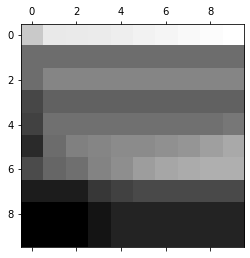

In [19]:
som = SOM(10, 10, 1.1, 0.6)
print("Training!")
som.train(norm, 100)
print("Mapping Data!")
som.mapData(norm)
print("Plotting Distance Map")
dm = som.getDistanceMap()
plt.matshow(dm, cmap = plt.cm.gray)
plt.show()

# 4. Get Outliers

In [20]:
outNodes = som.getOutliers(0.9, dm, som.somMap)
np.set_printoptions(suppress=True)
print(len(outNodes))

o = [np.array(x.vectors)*np.linalg.norm(data) for x in outNodes]
print(o)

6
[array([[  0.   ,  21.67 ,  11.5  , ...,   2.   ,   0.   ,   1.   ],
       [  1.   ,  17.42 ,   6.5  , ...,   2.   ,  60.   , 101.   ],
       [  0.   ,  55.75 ,   7.08 , ...,   2.   , 100.   ,  51.   ],
       ...,
       [  1.   ,  35.25 ,  16.5  , ...,   2.   ,  80.   ,   1.   ],
       [  1.   ,  31.57 ,  10.5  , ...,   2.   ,   0.   ,   1.   ],
       [  1.   ,  20.67 ,   0.415, ...,   2.   ,   0.   ,  45.   ]]), array([[  1.   ,  21.5  ,  11.5  ,   2.   ,   3.   ,   4.   ,   0.5  ,
          1.   ,   0.   ,   0.   ,   1.   ,   2.   , 100.   ,  69.   ],
       [  0.   ,  20.67 ,   3.   ,   2.   ,  11.   ,   4.   ,   0.165,
          1.   ,   1.   ,   3.   ,   0.   ,   2.   , 100.   ,   7.   ],
       [  1.   ,  19.42 ,   1.5  ,   1.   ,  13.   ,   4.   ,   2.   ,
          1.   ,   0.   ,   0.   ,   1.   ,   2.   , 100.   ,  21.   ],
       [  0.   ,  20.83 ,   3.   ,   2.   ,   6.   ,   4.   ,   0.04 ,
          1.   ,   0.   ,   0.   ,   0.   ,   2.   , 100.   ,   1.   ],
   

In [21]:
outliers = []

for node in o:
    for i in range(len(node)):
        for j in range(len(data)):
            if node[i].tolist() == data[j]:
                outliers.append(df.iloc[j].values.tolist())
                print(j)     

3
6
25
36
37
40
45
47
65
70
71
78
82
87
89
91
97
98
99
104
107
108
112
122
133
158
161
173
176
177
179
183
187
212
215
221
226
231
233
237
239
250
259
260
261
269
279
286
287
288
300
307
311
313
314
315
321
323
327
330
337
344
357
359
360
364
367
383
388
389
390
393
408
411
415
417
433
442
445
461
464
469
470
479
484
492
503
513
514
517
529
542
547
549
550
553
558
560
561
564
565
566
569
577
587
596
599
605
612
616
624
634
638
643
644
647
658
659
667
669
672
675
680
681
685
67
341
370
571
687
281
5
157
636
216
253
340
410
425
462


In [22]:
k = pd.DataFrame(outliers)
k.columns = df.columns
k

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15687688.0,0.0,21.67,11.500,1.0,5.0,3.0,0.000,1.0,1.0,11.0,1.0,2.0,0.0,1.0,1.0
1,15726466.0,1.0,17.42,6.500,2.0,3.0,4.0,0.125,0.0,0.0,0.0,0.0,2.0,60.0,101.0,0.0
2,15714087.0,1.0,32.75,1.500,2.0,13.0,8.0,5.500,1.0,1.0,3.0,1.0,2.0,0.0,1.0,1.0
3,15686461.0,1.0,25.00,12.500,2.0,6.0,4.0,3.000,1.0,0.0,0.0,1.0,1.0,20.0,1.0,1.0
4,15678882.0,1.0,39.58,13.915,2.0,9.0,4.0,8.625,1.0,1.0,6.0,1.0,2.0,70.0,1.0,1.0
5,15631685.0,1.0,23.17,0.000,2.0,13.0,4.0,0.085,1.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0
6,15738487.0,0.0,20.75,10.250,2.0,11.0,4.0,0.710,1.0,1.0,2.0,1.0,2.0,49.0,1.0,1.0
7,15737627.0,1.0,16.17,0.040,2.0,8.0,4.0,0.040,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0
8,15777994.0,1.0,42.00,9.790,2.0,14.0,8.0,7.960,1.0,1.0,8.0,0.0,2.0,0.0,1.0,1.0
9,15692137.0,1.0,48.75,26.335,1.0,1.0,1.0,0.000,1.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0
